In [27]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input/movielens-25m-dataset'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/movielens-25m-dataset/ml-25m-README.html
/kaggle/input/movielens-25m-dataset/ml-25m/ml-25m/movies.csv
/kaggle/input/movielens-25m-dataset/ml-25m/ml-25m/ratings.csv
/kaggle/input/movielens-25m-dataset/ml-25m/ml-25m/genome-tags.csv
/kaggle/input/movielens-25m-dataset/ml-25m/ml-25m/README.txt
/kaggle/input/movielens-25m-dataset/ml-25m/ml-25m/genome-scores.csv
/kaggle/input/movielens-25m-dataset/ml-25m/ml-25m/tags.csv
/kaggle/input/movielens-25m-dataset/ml-25m/ml-25m/links.csv


In [16]:
# !ls -R /kaggle/input/movielens-25m-recsys

In [24]:
import os, json, glob, pandas as pd

SLUG = "movielens-25m-recsys"               
BASE = f"/kaggle/input/{SLUG}/outputs"        

with open(f"{BASE}/manifest.json") as f:
    man = json.load(f)

parts = sorted(glob.glob(os.path.join(BASE, man["parquet"]["candidate_parts_glob"])))
candidates   = pd.concat([pd.read_parquet(p) for p in parts], ignore_index=True)

item_features = pd.read_parquet(os.path.join(BASE, man["parquet"]["item_features"]))
user_genre    = pd.read_parquet(os.path.join(BASE, man["parquet"]["user_genre"]))
valid_labels  = pd.read_parquet(os.path.join(BASE, man["parquet"]["valid_label"]))
test_labels   = pd.read_parquet(os.path.join(BASE, man["parquet"]["test_label"]))

In [28]:
import os, pandas as pd, numpy as np, matplotlib.pyplot as plt
from sklearn.preprocessing import normalize

DATA_DIR = "/kaggle/input/movielens-25m-dataset/ml-25m/ml-25m/"
OUT_DIR  = "/kaggle/working/outputs/parquet"
FIG_DIR  = "/kaggle/working/figure"
os.makedirs(OUT_DIR, exist_ok=True)
os.makedirs(FIG_DIR, exist_ok=True)

In [29]:
ratings = pd.read_csv(f"{DATA_DIR}/ratings.csv")
movies = pd.read_csv(f"{DATA_DIR}/movies.csv")
print(ratings.shape, movies.shape)
ratings.head()

(25000095, 4) (62423, 3)


,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510


## 1) Simple EDA

Unique users: 162541
Unique movies: 59047


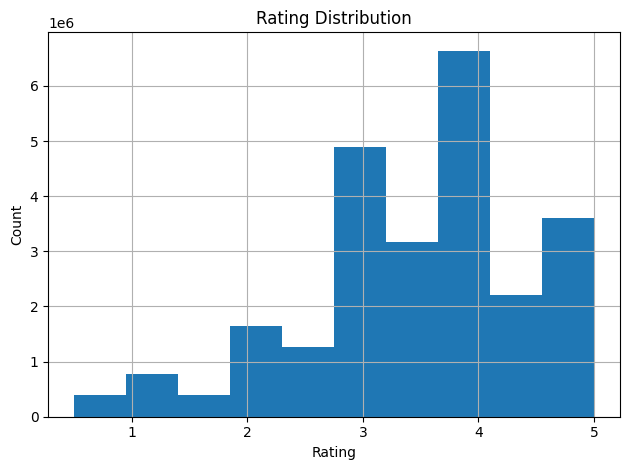

Sparsity (density): 0.00260484


In [30]:
print("Unique users:", ratings["userId"].nunique())
print("Unique movies:", ratings["movieId"].nunique())

ax = ratings["rating"].hist(bins=10)
ax.set(title="Rating Distribution", xlabel="Rating", ylabel="Count")
plt.tight_layout()
plt.savefig(f"{FIG_DIR}/fig_rating_hist.png", dpi=160)
plt.show()

n_users = ratings["userId"].nunique()
n_items = ratings["movieId"].nunique()
density = len(ratings) / (n_users * n_items)
print(f"Sparsity (density): {density:.8f}")

## 2) K-core Filtering

In [31]:
def kcore(df, k=10):
    d = df
    while True:
        before = len(d)
        d = d[d.groupby("userId")["userId"].transform("count") >=k ]    # users more than x10
        d = d[d.groupby("movieId")["movieId"].transform("count") >=k ]  # movies rated more than x10
        after = len(d)
        if before==after: 
            break
    return d.reset_index(drop=True)

In [32]:
ratings_core = kcore(ratings, k=10)
print("After k-core:", ratings_core.shape)

After k-core: (24890566, 4)


## 3) Extract recent data

In [35]:
# Change the format of timestamp
ratings["ts"] = pd.to_datetime(ratings["timestamp"], unit="s")
ratings = ratings.sort_values("ts").reset_index(drop=True)
ratings[["userId", "movieId", "rating", "ts"]].head()

# Use the data of 2015-current
min_year = 2015
ratings = ratings[ratings["ts"].dt.year >= min_year].reset_index(drop=True)
ratings.shape

(7563741, 5)

## 4) Split train set to train and validation sets (based on chronological order)

In [36]:
train = ratings.iloc[:int(len(ratings)*0.8)].copy()
valid = ratings.iloc[int(len(ratings)*0.8):int(len(ratings)*0.9)].copy()
test = ratings.iloc[int(len(ratings)*0.9):].copy()

len(train), len(valid), len(test)

(6050992, 756374, 756375)

## 5) Item Features
### : Count, Mean, Recency, Genre one-hot encoding

In [40]:
from sklearn.preprocessing import LabelEncoder

# Label Encode
le_u, le_i = LabelEncoder(), LabelEncoder()
train["u"] = le_u.fit_transform(train["userId"])
train["i"] = le_i.fit_transform(train["movieId"])

def encode_u_i(df):
    d = df[df["userId"].isin(le_u.classes_) & df["movieId"].isin(le_i.classes_)].copy()
    
    d["u"] = le_u.transform(d["userId"])
    d["i"] = le_i.transform(d["movieId"])

    return d

valid = encode_u_i(valid)
test = encode_u_i(test)

# count, mean, recency
item_stats = (train.groupby("i").agg(item_count=("rating", "size"),    # popularity
                                     item_mean=("rating", "mean"),     # quality
                                     item_last_ts=("ts", "max")).reset_index())    # recency

# normalized recency score (0–1) relative to the min(earliest) timestamp
ts_min = item_stats["item_last_ts"].min()
ts_max = item_stats["item_last_ts"].max()
denom = (ts_max - ts_min).total_seconds() or 1
item_stats["item_recency01"] = (item_stats["item_last_ts"] - ts_min).dt.total_seconds() / denom

### genre
# exclude cold-start (use only encoded by ratings.csv)
movies = movies[movies["movieId"].isin(le_i.classes_)].copy()
movies["i"] = le_i.transform(movies["movieId"])

# Preprocessing for "genre" -> new feature
movies["genres"] = movies["genres"].fillna("(no genres listed)")
movies["genres_list"] = movies["genres"].str.split("|")

all_genres = sorted({g for gl in movies["genres_list"] for g in gl})

for g in all_genres:
    movies[f"genre_{g}"] = movies["genres_list"].apply(lambda L: int(g in L))

# merge item_stats on movies dataframe
movie_feats = movies.merge(item_stats, on="i", how="left")

movie_feats["item_count"] = movie_feats["item_count"].fillna(0) 
movie_feats["item_mean"] = movie_feats["item_mean"].fillna(movie_feats["item_mean"].median())
movie_feats["item_recency01"] = movie_feats["item_recency01"].fillna(0)

# selecting the final item feature columns to be used -> final data frame: 'item_features'
genres_cols = [c for c in movie_feats.columns if c.startswith("genre_")]
item_cols = ["i", "movieId", "title", "item_count", "item_mean", "item_recency01"] + genres_cols

item_features = movie_feats[item_cols].copy()

for c in genres_cols:
    item_features[c] = item_features[c].astype("uint8")    # int64 -> unit8

# change dtype (memory)
item_features["item_count"] = item_features["item_count"].astype("int32")
item_features["item_mean"] = item_features["item_mean"].astype("float32")
item_features["item_recency01"] = item_features["item_recency01"].astype("float32")

item_features.shape

(49330, 26)

## 6) User's genre preference

In [41]:
genre_cols = [c for c in item_features.columns if c.startswith("genre_")]

# get mean (one-hot vec) of genres by each user
# which genre each user prefers
user_genre = (
    train.merge(item_features[["i"] + genre_cols], on="i").groupby("u")[genre_cols].mean().fillna(0.0)
)

# user_genre.head()

# L2 normalization -> cosine similarity with dot product
user_genre = pd.DataFrame(
    normalize(user_genre.values, axis=1), index=user_genre.index, columns = genre_cols
).astype("float32")

print(item_features.shape, user_genre.shape)

(49330, 26) (37938, 20)


## EDA Figures

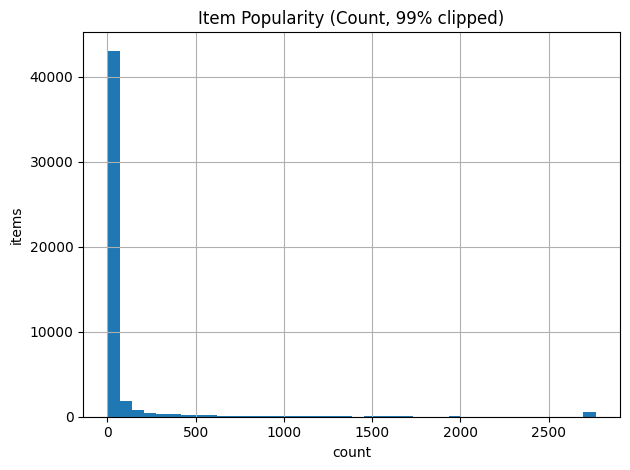

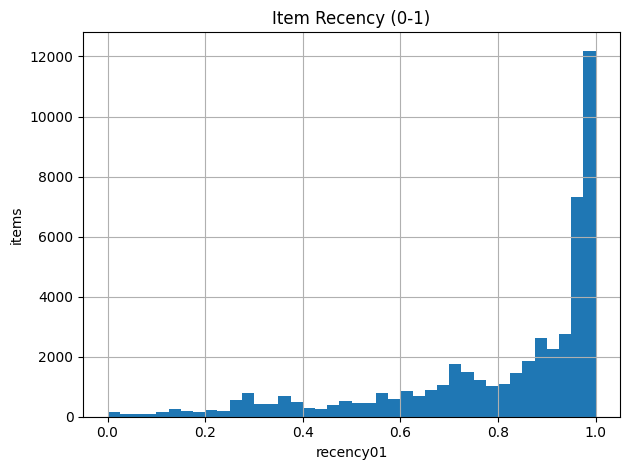

In [42]:
ax = item_features["item_count"].clip(upper=item_features["item_count"].quantile(0.99)).hist(bins=40)
ax.set(title="Item Popularity (Count, 99% clipped)", xlabel="count", ylabel="items")
plt.tight_layout(); plt.savefig(f"{FIG_DIR}/fig_item_popularity.png", dpi=160); plt.show()

ax = item_features["item_recency01"].hist(bins=40)
ax.set(title="Item Recency (0-1)", xlabel="recency01", ylabel="items")
plt.tight_layout(); plt.savefig(f"{FIG_DIR}/fig_item_recency.png", dpi=160); plt.show()


In [43]:
item_features.to_parquet(f"{OUT_DIR}/item_features.parquet", index=False)
user_genre.to_parquet(f"{OUT_DIR}/user_genre.parquet", index=True)
print("Saved:", OUT_DIR)

Saved: /kaggle/working/outputs/parquet
